# Exercise 4: THE DRIFT-DIFFUSION MODEL
## Cognitive Modeling Lecture 2024/25

This notebook is based on a tutorial provided by Max Shinn as part of the BAMB! summer school.

In [1]:
# If running through Google Colab, run this cell to install pyddm
!pip -q install pyddm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm

In [ ]:
#@title 1. Define a model and run the PyDDM model GUI to explore parameters
import pyddm
import pyddm.plot
import numpy as np
model = pyddm.gddm(drift="driftrate",
                   noise="c",
                   bound=lambda t,initial_B,collapse_rate : initial_B * np.exp(-collapse_rate*t),
                   starting_position="x0",
                   parameters={"driftrate": (-3, 3),
                               "initial_B": (.5, 1.5),
                               "collapse_rate": (0, 10),
                               "x0": (-.9, .9),
                               "c": (0.1, 2)})

pyddm.plot.model_gui_jupyter(model)
# pyddm.plot.model_gui(model) # If not using a Jupyter notebook or Google Colab

This demo can be run like a normal Jupyter notebook. If you've never used Jupyter notebooks before, hover over both headings below ("Install PyDDM on Google Colab" and "Define the model and run the GUI") and press the play button on each. An interactive demo will show below. To make changes to the model and try out your changes, click on "Show code" and edit it. When you are done, click on the play button again to update the demo.

## 2. *(optional)* Simulating the drift-diffusion model by hand
We're going to simulate the drift-diffusion model in a variety of conditions and study of patterns of reaction times and responses that it produces, to develop some intutions on how the different parameters impact the behavior produced. The idea is to learning how the DDM works, but in practice, it is better to use an optimised library for simulating DDMs in your research.  In parts 2-4, we will learn to use one such library.

### a) Write a function to simulate the DDM

In [ ]:
def run_ddm(drift_rate=.5, noise=.8, bound=1.2, dt=.01, T_dur=4):
    """
    Simulate single run of discrete DDM (stores trajectory of decision variable)

    [X, side, RT] = run_ddm(v, a, z, dt)

    Input:
        drift_rate: drift rate
        noise: standard deviation of noise
        bound: the threshold(lower boundary corresponds to -a, upper boundary to a)
        dt: time step for discretized version of dynamics
        T_dur: total runtime, in seconds

    Output:
        X: vector with dynamics of the decision variable until hitting the boundary
        side: +1 if DV hits the upper boundary, -1 if DV hits the lower boundary
        RT: reaction time

    """

    tmax = int(T_dur/dt);   # maximum number of time steps

    # Initialize decision variable x to 0
    x = 0

    # Vector of all values of DV
    X = [x]

    # Looping through time
    for t in range(tmax):
        x += drift_rate*dt + np.sqrt(dt) * noise * np.random.randn() # discrete DDM equation: update of decision variable

        X.append(x) # append x to vector of DV

        # check boundary conditions
        if x <= -bound:
            side = -1
            break
        if x >= bound:
            side = 1
            break
    else: # executed if no break has occurred in the for loop
        # If no boundary is hit before maximum time,
        # choose according to decision variable value
        choice = 1 if x > 0 else -1

    rt = t*dt
    return X, side, rt

# Or, alternatively, the vectorized four-line version
def run_ddm(drift_rate, noise=.5, bound=1, T_dur=4, dt=.01):
    # Run the actual trajectory
    trajectory = np.cumsum(drift_rate*dt + noise*np.sqrt(dt)*np.random.randn(int(T_dur/dt)))
    # Find the first place where it crosses the upper or lower bound.  If there
    # was no bound crossing, consider the RT to be the end time (forcing a
    # choice).
    RT_index = min(np.where(np.abs(trajectory)>bound)[0], default=len(trajectory)-1)
    # Calculate the RT from the bound crossing
    RT = RT_index * dt
    # Check whether it is the upper or lower bound we crossed.  This also
    # handles the case where the trial didn't terminate, i.e., where RT_index
    # is the last element in the trajectory, by taking the bound it was closest
    # to.
    choice = int(trajectory[RT_index] > 0)
    return trajectory[0:RT_index], choice, RT



Once you have written this function, use it simulate 5 trials and plot dynamics of the decision variable and bounds
Use parameter values: drift = 0.5, bound = 1.2, and no non-decision-time.
Use time step dt = 0.001 and a duration of 4 sec.

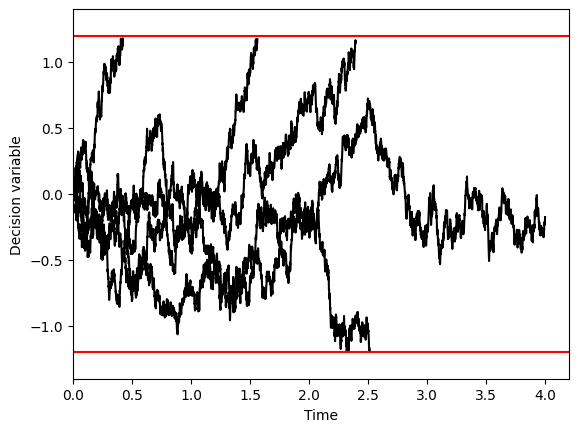

In [ ]:
bound = 1.2
noise = .8
drift_rate = .5
T_dur = 4
dt = .001
for i_trial in range(5): # for each trial
    X, _, _ = run_ddm(drift_rate=drift_rate, bound=bound, noise=noise, dt=dt, T_dur=T_dur) # simulate my DDM
    plt.plot(dt*np.arange(0, len(X)), X, c='k')

plt.xlabel('Time')
plt.ylabel('Decision variable')
plt.ylim((-bound-.2, bound+.2))
plt.xlim(0, T_dur+.2)
plt.axhline(-bound, c='r')
plt.axhline(bound, c='r')

Repeat with 500 trials.  Add transparency of 0.01 to the lines so that you can still see the density.

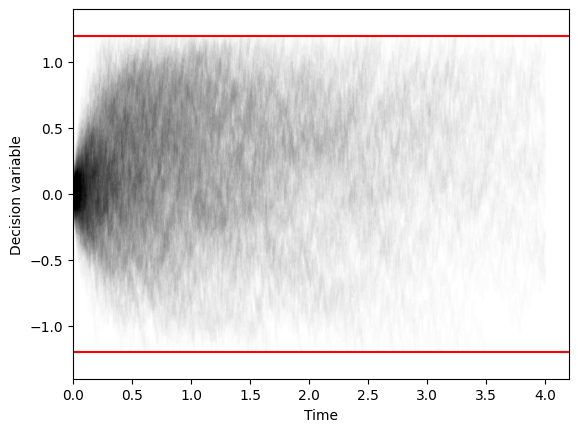

In [ ]:
for i_trial in range(500): # for each trial
    X, _, _ = run_ddm(drift_rate=drift_rate, bound=bound, noise=noise, dt=.001, T_dur=T_dur) # simulate my DDM
    plt.plot(dt*np.arange(0, len(X)), X, c='k', alpha=.01)

plt.xlabel('Time')
plt.ylabel('Decision variable')
plt.ylim((-bound-.2, bound+.2))
plt.xlim((0, T_dur+.2))
plt.axhline(bound, c='r')
plt.axhline(-bound, c='r')

Notice with transparency that you can see the density of particles which hit a given point.  We will come back to this in Part II.

### b) Plot the RT distribution
Run the DDM 10000 times.  We don't care about the trajectories here, but we do care about the RT and the choice that was made. Plot a histogram, separately for correct and incorrect responses.
Use parameters: drift = 0.5, bound = 1.2, noise = 0.8, dt=.005, T_dur = 4.  Also include a non-decision time of 0.3 s.

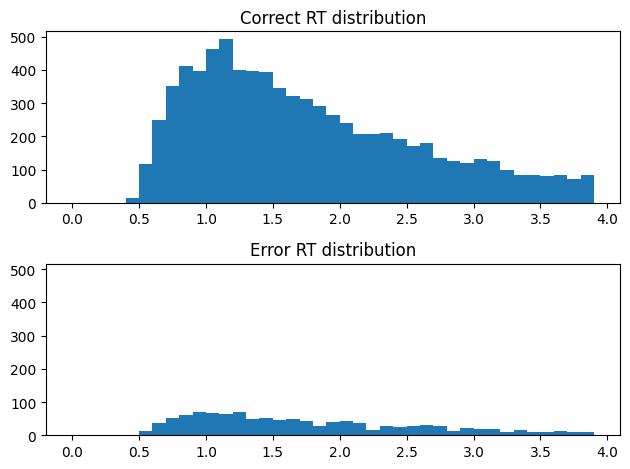

In [ ]:
N_trials = 10000
drift_rate = .5
bound = 1.2
noise = .8
dt = .005
T_dur = 4
non_decision_time = .3

correct_rts = []
error_rts = []
for i in range(0, N_trials):
    _, resp, rt = run_ddm(drift_rate=drift_rate, noise=noise, bound=bound, dt=dt, T_dur=T_dur)
    if resp > 0:
        correct_rts.append(rt + non_decision_time)
    else:
        error_rts.append(rt + non_decision_time)

ax1 = plt.subplot(2,1,1)
h = plt.hist(correct_rts, bins=np.arange(0, T_dur, dt*20))
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.hist(error_rts, bins=np.arange(0, T_dur, dt*20))
plt.title("Error RT distribution")
plt.tight_layout()


# 3. Simulating the drift-diffusion model with PyDDM
In practice, we generally want to perform simulations with a simulator instead of by hand.  This is because there are more efficient solutions than simulating individual trajectories.  For instance, many DDMs have closed-form mathematical expressions for the RT distribution.  For those that don't, it is possible to simulate the entire probability distribution of evolving particle density instead of individual particles one by one.

You may find it useful in this section and later sections to consult the [PyDDM documentation](https://pyddm.readthedocs.io/en/stable/), especially the [cookbook](https://pyddm.readthedocs.io/en/stable/cookbook/index.html) and the [quick start guide](https://pyddm.readthedocs.io/en/stable/quickstart.html).

### a) Simulate 10000 trials of the drift-diffusion model with PyDDM and plot the RT distribution
Hint: You will want to create a PyDDM Model object, solve it, and then use the "resample" function on the solution.

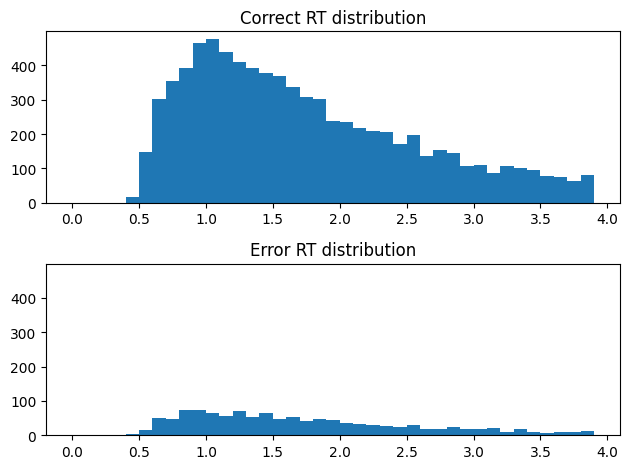

In [ ]:
import pyddm
m = pyddm.Model(drift=pyddm.DriftConstant(drift=.5), noise=pyddm.NoiseConstant(noise=.8), bound=pyddm.BoundConstant(B=1.2), overlay=pyddm.OverlayNonDecision(nondectime=.3), T_dur=T_dur)
sol = m.solve()
sample = sol.resample(10000)
correct_rts = sample.corr
error_rts = sample.err

ax1 = plt.subplot(2,1,1)
plt.hist(correct_rts, bins=np.arange(0, T_dur, 20*.005))
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.hist(error_rts, bins=np.arange(0, T_dur, 20*.005))
plt.title("Error RT distribution")
plt.tight_layout()

### b) Simulate an infinite number of trials of the drift-diffusion model and plot the density
Hint: Every "solution" object contains the full RT distribution as pdf("correct") and pdf("error"), so this should be easier than (a)

Text(0.5, 1.0, 'Error RT distribution')

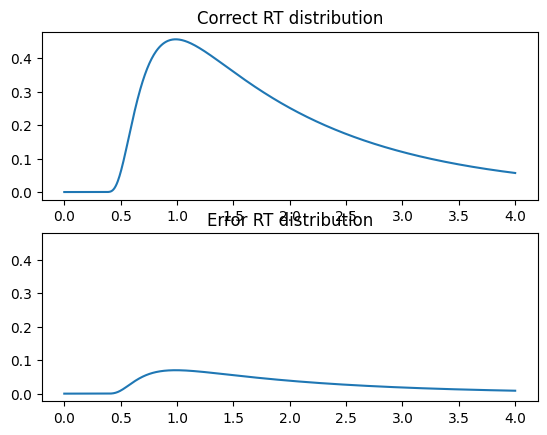

In [ ]:
import pyddm
m = pyddm.Model(drift=pyddm.DriftConstant(drift=.5), noise=pyddm.NoiseConstant(noise=.8), bound=pyddm.BoundConstant(B=1.2), overlay=pyddm.OverlayNonDecision(nondectime=.3), T_dur=T_dur)
sol = m.solve()

correct_pdf = sol.pdf("correct")
error_pdf = sol.pdf("error")

ax1 = plt.subplot(2,1,1)
plt.plot(m.t_domain(), correct_pdf)
plt.title("Correct RT distribution")
plt.subplot(2,1,2, sharey=ax1)
plt.plot(m.t_domain(), error_pdf)
plt.title("Error RT distribution")

### c) Use the following code to explore how the RT distribution depends on drift, noise, and bound
Note: The "Fittable" object is a placeholder for a value which has not yet been fit to data.  We will see it again when we fit models to data below.
Hint: Check the "real-time" checkbox once the model gui starts in order to update the plot as you drag the sliders

In [ ]:
import pyddm
from pyddm.plot import model_gui_jupyter
m = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-2, maxval=2, default=.5)), noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=1, default=.8)), bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=.3, maxval=1.5, default=1.2)), overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5, default=.3)), T_dur=4, dt=.001)
model_gui_jupyter(m)

Output()

# 4. Fitting the drift-diffusion model

### a) Fit a simple DDM for a single subject
We will fit the DDM to a non-human primate subject from [Roitman and Shadlen (2002)](https://www.jneurosci.org/content/22/21/9475) performing the random dot motion task.

[Download data](https://pyddm.readthedocs.io/en/latest/_downloads/bcc1102d5b69c49dac52b49536b87240/roitman_rts.csv)


In [ ]:
import pyddm
import pyddm.plot
import pandas

#First, load the data we wish to use
df_rt = pandas.read_csv("https://raw.githubusercontent.com/mwshinn/PyDDM/master/doc/downloads/roitman_rts.csv")

df_rt = df_rt[df_rt["monkey"] == 1] # Only monkey 1
sample = pyddm.Sample.from_pandas_dataframe(df_rt, rt_column_name="rt", correct_column_name="correct")

First, let's fit a model that ignores the coherence.  It is probably not going to be a very good model, but it will show us how to fit a model in PyDDM.  We will fit the previous model we built.

In [ ]:
m = pyddm.Model(drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
          noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
          overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

Now we perform the fit

In [ ]:
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

Info: Params [1.54468887 1.42896274 0.28038462] gave 1028.431105454476
Info:pyddm:Params [1.54468887 1.42896274 0.28038462] gave 1028.431105454476


Model(name='', drift=DriftConstant(drift=Fitted(1.5446888744461447, minval=-5, maxval=5)), noise=NoiseConstant(noise=Fitted(1.428962744135703, minval=0.1, maxval=2)), bound=BoundConstant(B=1), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.28038462002142295, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=2.0, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='Negative log likelihood', value=1028.431105454476, nparams=3, samplesize=2615, mess=''))

Show information about the fit.

In [ ]:
pyddm.display_model(m)

Model information:
Choices: 'correct' (upper boundary), 'error' (lower boundary)
Drift component DriftConstant:
    constant
    Fitted parameters:
    - drift: 1.544689
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 1.428963
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPointSourceCenter:
    point_source_center
    (No parameters)
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fitted parameters:
    - nondectime: 0.280385
Fit information:
    Loss function: Negative log likelihood
    Loss function value: 1028.431105454476
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 3
        - samplesize: 2615
        - mess: ''



We can also use the model gui again, but this time, to visualise the fit that we just performed.

In [ ]:
pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

### b) Fitting a coherence-dependent DDM to a single subject

Notice how behaviour is different depending on the coherence of the random dot motion.  So, we need a Drift class which depends on the coherence condition.  For this, [here is one from the PyDDM documentation](https://pyddm.readthedocs.io/en/latest/cookbook/driftnoise.html#drift-coh).  The bulk of this is implementing the get_drift function, which returns the drift value at a given time, position in space, and task conditions.  Here, we want the drift to be constant over time and space, but different for different task conditions.  So, we will use the "conditions" argument, and ignore the "t" and "x" arguments.

In [ ]:
class DriftCoherence(pyddm.Drift):
    name = "Drift linearly depending on coherence"
    required_conditions = ["coh"] # This is from the Roitman-Shadlen dataset
    required_parameters = ["drift"] # We can name this parameter anything we want
    def get_drift(self, t, x, conditions, **kwargs):
        return conditions['coh'] * self.drift

Now, we can construct the final model and fit it to data.  Create a Model object which uses your new Drift class and visualise it with your sample using pyddm.plot.model_gui_jupyter.

In [ ]:
m = pyddm.Model(drift=DriftCoherence(drift=pyddm.Fittable(minval=-20, maxval=20)),
          noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
          overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

Output()

Now, fit your model to data using fit_adjust_model.  Use RobustLikelihood as a loss function.

In [ ]:
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

Info: Params [12.11286001  1.25778296  0.28383553] gave 358.1740777662922
Info:pyddm:Params [12.11286001  1.25778296  0.28383553] gave 358.1740777662922


Model(name='', drift=DriftCoherence(drift=Fitted(12.112860006457757, minval=-20, maxval=20)), noise=NoiseConstant(noise=Fitted(1.2577829554813191, minval=0.1, maxval=2)), bound=BoundConstant(B=1), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.2838355308503759, minval=0, maxval=0.5)), dx=0.005, dt=0.005, T_dur=2.0, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='Negative log likelihood', value=358.1740777662922, nparams=3, samplesize=2615, mess=''))

### c) (optional) Plot the psychometric and chronometric functions
The psychometric function shows the coherence/evidence on the x axis and the probability of a correct response on the y axis.  Likewise, the chronometric function shows the coherence/evidence on the x axis and the mean RT of correct responses on the y axis.

Hint: PyDDM model Solutions (the output of m.solve()) have a prob("correct") and prob("error") methods, as well as mean_decision_time() function.

Hint 2: PyDDM Samples have these methods too!  You might also want to use the "subset" method.

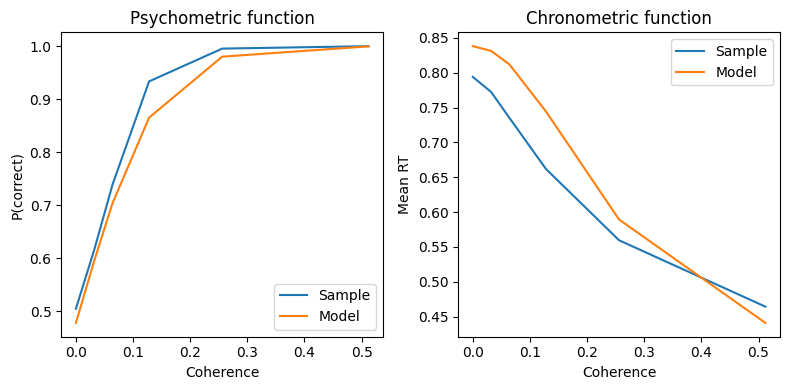

In [ ]:
coherences = sorted(sample.condition_values('coh'))
psychometric_model = [m.solve(conditions={"coh": coh}).prob("correct") for coh in coherences]
psychometric_sample = [sample.subset(coh=coh).prob("correct") for coh in coherences]
chronometric_model = [m.solve(conditions={"coh": coh}).mean_decision_time() for coh in coherences]
chronometric_sample = [sample.subset(coh=coh).mean_decision_time() for coh in coherences]
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(coherences, psychometric_sample, label="Sample")
plt.plot(coherences, psychometric_model, label="Model")
plt.title("Psychometric function")
plt.xlabel("Coherence")
plt.ylabel("P(correct)")
plt.legend()
plt.subplot(1,2,2)
plt.plot(coherences, chronometric_sample, label="Sample")
plt.plot(coherences, chronometric_model, label="Model")
plt.title("Chronometric function")
plt.xlabel("Coherence")
plt.ylabel("Mean RT")
plt.legend()
plt.tight_layout()

### d) Adding an explicit model of lapse rate
What happens if the subject responds during the non-decision time?  Well, in theory, the model should give a likelihood of zero, and hence, a negative log likelihood of infinity.  (More generally, if there is even one "outlier" response at a time when the model predicts there should be none, this will have a large effect on the model.)  But when you look at our data, there are indeed a few responses during the non-decision time.  So why is the likelihood finite?

It is finite because we have been cheating a bit.  Notice how when we fit the model previously, we used "Robust Likelihood".  What robust likelihood does is add a small constant offset to the likelihood of each point before taking the logarithm.  Is this best practice?  No, but lots of people still do it.  So let's properly model the lapse trials in addition to the actual trials.

We do this using a mixture model.  We assume that X% of trials are generated by the DDM, and (100-X)% of trials are generated by some other process, for example, an evidence-independent probability distribution.  The two best choices to use for this are a uniform distribution, which assumes lapse trials are equally likely at any point in the trial, or an exponential distribution, which assumes lapse trials come from a poisson distribution (a flat hazard).

We implement mixture models in PyDDM using an overlay.  However, since we are already using an overlay for non-decision time, we need to chain overlays together using pyddm.OverlayChain.  This can be used as follows:

```
overlay=pyddm.OverlayChain(overlays=[overlay1, overlay2]),
```

where "overlay1" and "overlay2" are overlays.  See [the PyDDM documentation](https://pyddm.readthedocs.io/en/latest/apidoc/dependences.html#module-ddm.models.overlay) for a list of all overlays included by default.  Once you are using a mixture model to account for lapse/outlier responses, you can change the loss function from "LossRobustLikelihood" to "LossLikelihood".

Below, modify our model to use an error distribution with a uniform distribution.  Use a fittable mixture ratio.

In [ ]:
m = pyddm.Model(drift=DriftCoherence(drift=pyddm.Fittable(minval=-20, maxval=20)),
                noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
                overlay=pyddm.OverlayChain(overlays=[pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
                        pyddm.OverlayUniformMixture(umixturecoef=pyddm.Fittable(minval=.01, maxval=.5))]))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

# 5. *(optional)* Generalized drift-diffusion models
Generalized drift-diffusion models (GDDMs) allow going beyond the standard model parameters of the DDM.  Instead of drift, noise, and bound being fixed values, GDDMs allow them to be functions which may vary across time.  For example, this allows modelling tasks which have evidence that changes over time.  It also allows these to have complex, non-linear relationships with any number of task conditions and use any number of parameters.  For example, it is possible to model multisensory integration, with different streams of evidence contributing non-linearly to drift rate.  Furthermore, it also allows integration to be leaky (i.e. forgetting) or unstable (i.e. biasing early evidence), as well as representing an urgency signal (e.g. bounds which collapse over time).  There is evidence that these model properties are useful for modelling RTs in overtrained human or animal subjects.

All of these exercises are optional and do not depend on each other - feel free to skip around and do those which are of greatest interest.

### a) Collapsing boundaries
Sometimes, especially in the case of overtrained animals, more evidence may be needed to make a decision earlier in the trial compared to later in the trial.  Construct, visualise, and fit a model with linearly collapsing boundaries to the data from (3).  It might take a bit longer to fit.

In [ ]:
m = pyddm.Model(drift=DriftCoherence(drift=pyddm.Fittable(minval=-20, maxval=20)),
                noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
                overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)),
                bound=pyddm.BoundCollapsingExponential(B=1, tau=pyddm.Fittable(minval=.01, maxval=3)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

In [ ]:
pyddm.fit_adjust_model(model=m, sample=sample, lossfunction=pyddm.LossRobustLikelihood, verbose=False)

### b) Leaky integration
Leaky integration occurs when the decision variable is constantly being pushed back to zero (a stable fixed point at zero).  This models forgetting, or alternatively, prioritising more recent evidence.  This is implemented in the model by making the drift rate depend on the position of the particle at any given time.  Construct and visualise a leaky integration model by modifying the DriftCoherence model above.  You do not need to fit it to data, since this may take a few minutes (and can be done the same way as all the above examples).  Note that leak can be negative: this is also called "unstable integration".

In [ ]:
class DriftCoherenceLeaky(pyddm.Drift):
    name = "Drift linearly depending on coherence"
    required_conditions = ["coh"] # This is from the Roitman-Shadlen dataset
    required_parameters = ["drift", "leak"] # We can name these parameters anything we want
    def get_drift(self, t, x, conditions, **kwargs):
        return conditions['coh'] * self.drift - x * self.leak

m = pyddm.Model(drift=DriftCoherenceLeaky(drift=pyddm.Fittable(minval=-20, maxval=20), leak=pyddm.Fittable(minval=-2, maxval=2)),
                noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
                overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

### c) Side bias
In our dataset, we also have information about which side the monkey chose to get the correct answer ("trgchoice" in the Roitman dataset, which has values "1" or "2").  Let's use a GDDM to implement a side bias.

There are two common ways to implement a side bias.  The first is to assume that the biased side causes a constant offset bias on the drift rate.  So, in the 0% coherence condition, the drift rate will be towards the biased side.  Likewise, in a strong evidence condition, the drift rate will be stronger if it is on the same side as the bias.  This can be implemented by adding "trgchoice" as a "required_condition" to the drift rate and a parameter "side_bias" to describe the magnitude of the bias.  Then, when computing the drift function, add "side_bias" to the result if it is on the preferred side, and otherwise, subtract "side_bias".

In [ ]:
class DriftCoherenceSideBias(pyddm.Drift):
    name = "Drift depending on coherence with a side bias"
    required_conditions = ["coh", "trgchoice"] # This is from the Roitman-Shadlen dataset
    required_parameters = ["drift", "side_bias"] # We can name this parameter anything we want
    def get_drift(self, t, x, conditions, **kwargs):
        # Positive for side 1, negative for side 2
        bias = self.side_bias * (1 if conditions["trgchoice"] == 1 else -1)
        return conditions['coh'] * self.drift + bias

m = pyddm.Model(drift=DriftCoherenceSideBias(drift=pyddm.Fittable(minval=-20, maxval=20),
                                             side_bias=pyddm.Fittable(minval=-10, maxval=10)),
          noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
          overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

The other way is to assume that there is an offset in the starting position: instead of starting at zero, we start at some other point.  To do this, we need to implement a new InitialConditions, which takes the side as a condition and a parameter x0 of the magnitude of the bias.  Then, it returns a probability distribution where all the density is in a single point: the point x0 for one side, or -x0 for the other side.

See the [PyDDM documentation](https://pyddm.readthedocs.io/en/stable/cookbook/initialconditions.html#biased-initial-conditions) for an example.

In [ ]:
class ICPointSideBias(pyddm.InitialCondition):
    name = "A starting point with a left or right bias."
    required_parameters = ["x0"]
    required_conditions = ["trgchoice"]
    def get_IC(self, x, dx, conditions):
        start = np.round(self.x0/dx)
        # Positive bias for choices to side 1, negative for side 2
        if conditions['trgchoice'] == 2:
            start = -start
        shift_i = int(start + (len(x)-1)/2)
        assert shift_i >= 0 and shift_i < len(x), "Invalid initial conditions"
        pdf = np.zeros(len(x))
        pdf[shift_i] = 1. # Initial condition at x=self.x0.
        return pdf

m = pyddm.Model(drift=DriftCoherence(drift=pyddm.Fittable(minval=-20, maxval=20)),
          noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
          IC=ICPointSideBias(x0=pyddm.Fittable(minval=-.8, maxval=.8)),
          overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

### d) Distributions of starting positions and non-decision time
Suppose that, instead of starting at the position 0, the starting position of the integrator was pulled from a uniform distribution (where the size is a fittable parameter), and the non-decision time is pulled from a gamma distribution with fittable rate and shape parameters.

Hint: PyDDM has built-in an OverlayNonDecisionGamma, as well an ICRange which may be helpful.

In [ ]:
m = pyddm.Model(drift=DriftCoherence(drift=pyddm.Fittable(minval=-20, maxval=20)),
                noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
                overlay=pyddm.OverlayNonDecisionGamma(nondectime=pyddm.Fittable(minval=0, maxval=.5), shape=pyddm.Fittable(minval=1, maxval=2.5), scale=pyddm.Fittable(minval=0.01, maxval=1)),
                IC=pyddm.ICRange(sz=pyddm.Fittable(minval=0, maxval=.9)))

pyddm.plot.model_gui_jupyter(model=m, sample=sample)

### e) Evidence which changes over time
Evidence is not always the same over time.  For instance, many tasks present discrete pulses of evidence.  Others may have evidence which is constantly fluctuating (e.g. changes in motion energy).

To mode this in PyDDM, we need to create a custom Drift object, as we did above.  But this time, the get_drift function should use the "t" function argument.

Model a situation where we have two pulses of evidence, the first lasting from time 0.3 s to 0.6 s, and the second from 1.0 to 1.2 s.  Let the magnitude of each be given by the conditions "pulse1" and "pulse2".  Play with this model in the model_gui.

In [ ]:
import pyddm
import pyddm.plot
import numpy as np
class DriftPulses(pyddm.Drift):
    name = "Drift with two pulses"
    required_parameters = ["drift"]
    required_conditions = ["pulse1", "pulse2"]
    def get_drift(self, t, x, conditions, **_):
        if t > .3 and t <= .6:
            return self.drift * conditions['pulse1']
        elif t > 1.0 and t <= 1.2:
            return self.drift * conditions["pulse2"]
        else:
            return 0

m = pyddm.Model(drift=DriftPulses(drift=pyddm.Fittable(minval=0, maxval=20)),
          noise=pyddm.NoiseConstant(noise=pyddm.Fittable(minval=.1, maxval=2)),
          overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=.5)))

pyddm.plot.model_gui_jupyter(m, conditions={"pulse1": [0, .2, .4, .6], "pulse2": [0, .2, .4, .6]})